# 1. Project motivation

### From Life:
Breast cancer is the most fatal disease in women, so it is very important to detect symptoms of the disease and treat it promptly.

### From Technology: 
Deep learning is currently a very strong development direction of machine learning. We can use it in medicine with great results.

# 2. Dataset

### Breast Histopathology Images Dataset

Source: https://www.kaggle.com/paultimothymooney/breast-histopathology-images

### IDC
Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

### Describe the dataset
- The original dataset consisted of 279 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x.
- 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). 
- Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png.
        + Where u is the patient ID (10253idx5);
        + X is the x-coordinate of where this patch was cropped from; 
        + Y is the y-coordinate of where this patch was cropped from; 
        + C indicates the class where 0 is non-IDC and 1 is IDC.

# 3. Project plan

### - Input
Dataset: Breast Histopathology Images Dataset

### - Model
Deep learning:
- ANN
- CNN
- CapsNet

### - Output
Results of diagnosis

# 4. Data processing

### 4.1. Import libraries

In [136]:
import os
import re
import numpy as np
import seaborn as sns
from skimage.io import imread
import cv2
from sklearn.model_selection import train_test_split

import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
params = {
    'figure.figsize': (10, 10),
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
}
plt.rcParams.update(params)

In [43]:
data_dir = '../dataset'
folders = os.listdir(data_dir)

print('Number of patients: ' + str(len(folders)))

Number of patients: 279


### 4.2. Data initialization

In [94]:
regex_find_x = '_x.+_y'
regex_find_y = '_y.+_'

total_images = 0
patient_id = []
patient_x = []
patient_y = []
patient_path = []
patient_target = []

for i in folders:
    p_id = i
    
    for label in [0, 1]:
        p_path = data_dir + '/' + p_id + '/' + str(label)
        images = os.listdir(p_path)
        total_images += len(images)
        
        for i_path in images:
            image_path = p_path + '/' + i_path
            
            tmp_x = re.findall(regex_find_x, image_path)
            tmp_y = re.findall(regex_find_y, image_path)
            
            patient_id.append(int(p_id))
            patient_x.append(int(tmp_x[0][2:-2]))
            patient_y.append(int(tmp_y[0][2:-1]))
            patient_path.append(image_path)
            patient_target.append(int(label))
            
data_dict = {
    'patient_id': patient_id,
    'x': patient_x,
    'y': patient_y,
    'path': patient_path,
    'target': patient_target
}

In [95]:
data = pd.DataFrame(data = data_dict)

print('Number of images: ' + str(total_images))

Number of images: 277524


In [96]:
data.head(20)

,patient_id,x,y,path,target
0,15634,2101,751,../dataset/15634/0/15634_idx5_x2101_y751_class0.png,0
1,15634,2251,501,../dataset/15634/0/15634_idx5_x2251_y501_class0.png,0
2,15634,2151,2151,../dataset/15634/0/15634_idx5_x2151_y2151_class0.png,0
3,15634,1101,351,../dataset/15634/0/15634_idx5_x1101_y351_class0.png,0
4,15634,2651,651,../dataset/15634/0/15634_idx5_x2651_y651_class0.png,0
5,15634,1251,1101,../dataset/15634/0/15634_idx5_x1251_y1101_class0.png,0
6,15634,951,2101,../dataset/15634/0/15634_idx5_x951_y2101_class0.png,0
7,15634,851,401,../dataset/15634/0/15634_idx5_x851_y401_class0.png,0
8,15634,601,901,../dataset/15634/0/15634_idx5_x601_y901_class0.png,0
9,15634,951,2051,../dataset/15634/0/15634_idx5_x951_y2051_class0.png,0


### 4.3. Analyze and visualize data

#### Number of patches/patient

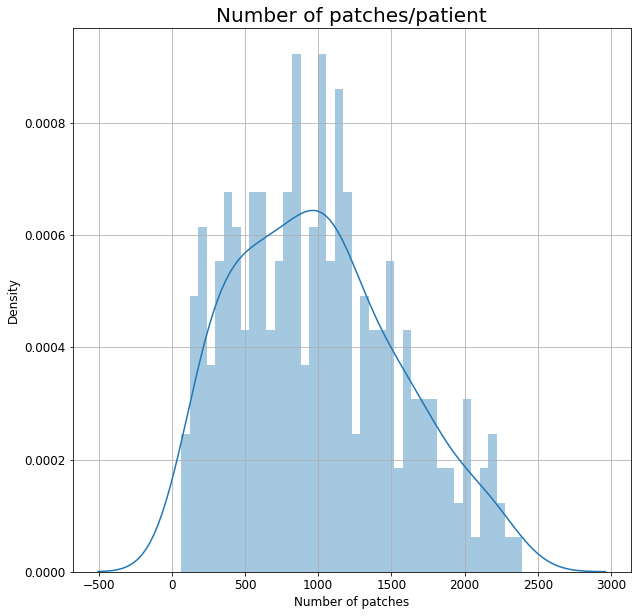

In [137]:
patch_each_patient = data.groupby('patient_id').target.size()

g = sns.distplot(patch_each_patient, bins=40)
g.set_xlabel('Number of patches')
g.set_ylabel('Density')
g.set_title('Number of patches/patient', fontsize=20)
g.grid()

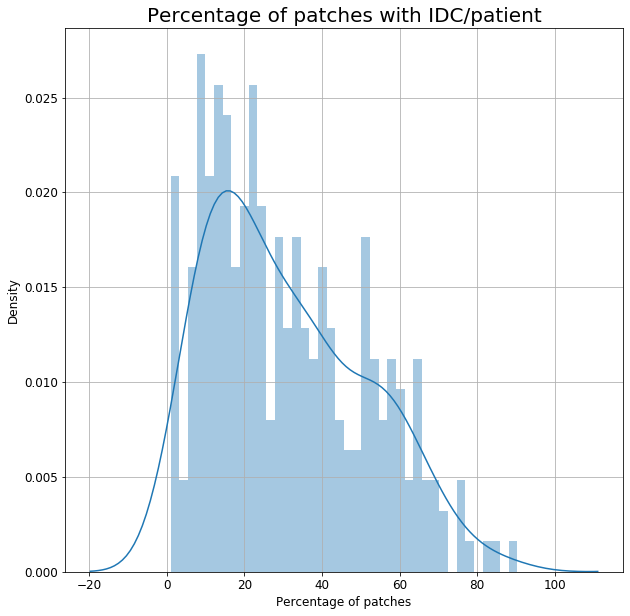

In [138]:
cancer_percentage = data.groupby('patient_id').target.value_counts() / data.groupby('patient_id').target.size()
cp = cancer_percentage.loc[:, 1] * 100

g = sns.distplot(cp, bins=40)
g.set_xlabel('Percentage of patches')
g.set_ylabel('Density')
g.set_title('Percentage of patches with IDC/patient', fontsize=20)
g.grid()

#### Percentage of patchs show IDC

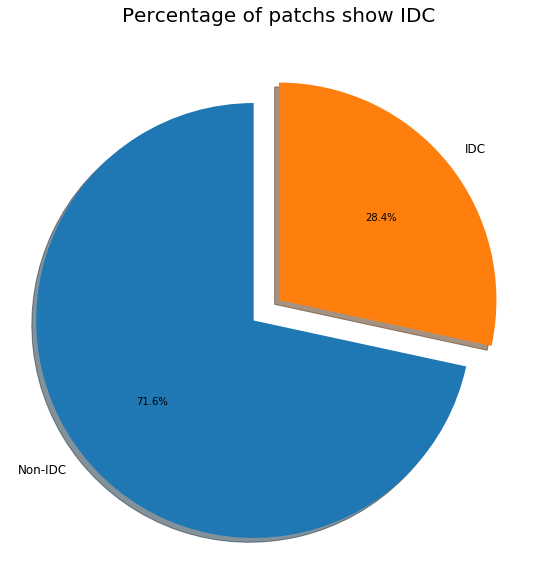

In [139]:
target_percentage = data.target.value_counts()
labels_tp = ['Non-IDC', 'IDC']
explode_tp = (0.15, 0)

plt.pie(target_percentage, explode=explode_tp, labels=labels_tp, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Percentage of patchs show IDC', fontsize=20)
# plt.legend()
plt.show()

#### IDC/Non-IDC patches samples

In [100]:
idc_sample = np.random.choice(data[data.target==1].index.values, size=32, replace=False)
non_idc_sample = np.random.choice(data[data.target==0].index.values, size=32, replace=False)

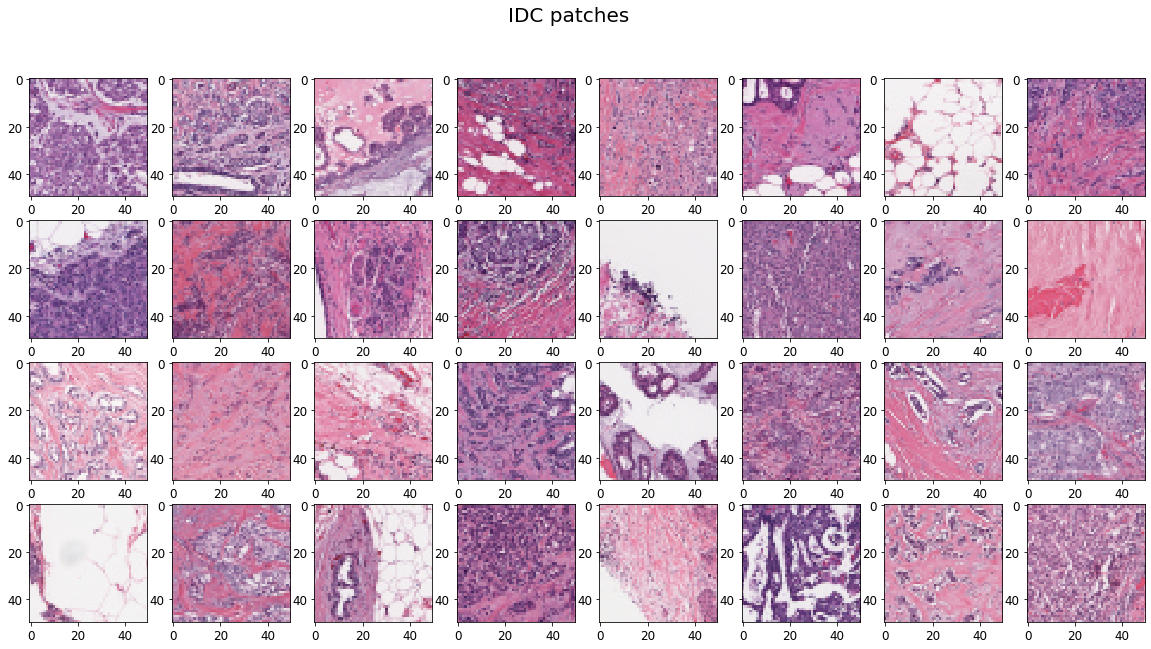

In [152]:
# IDC patches
fig, ax = plt.subplots(4, 8, figsize=(20, 10))

for i in range(4):
    for j in range(8):
        idx = idc_sample[j + 8*i]
        image = imread(data.loc[idx, 'path'])
        ax[i,j].imshow(image)
        
fig.suptitle('IDC patches', fontsize=20)
plt.show()

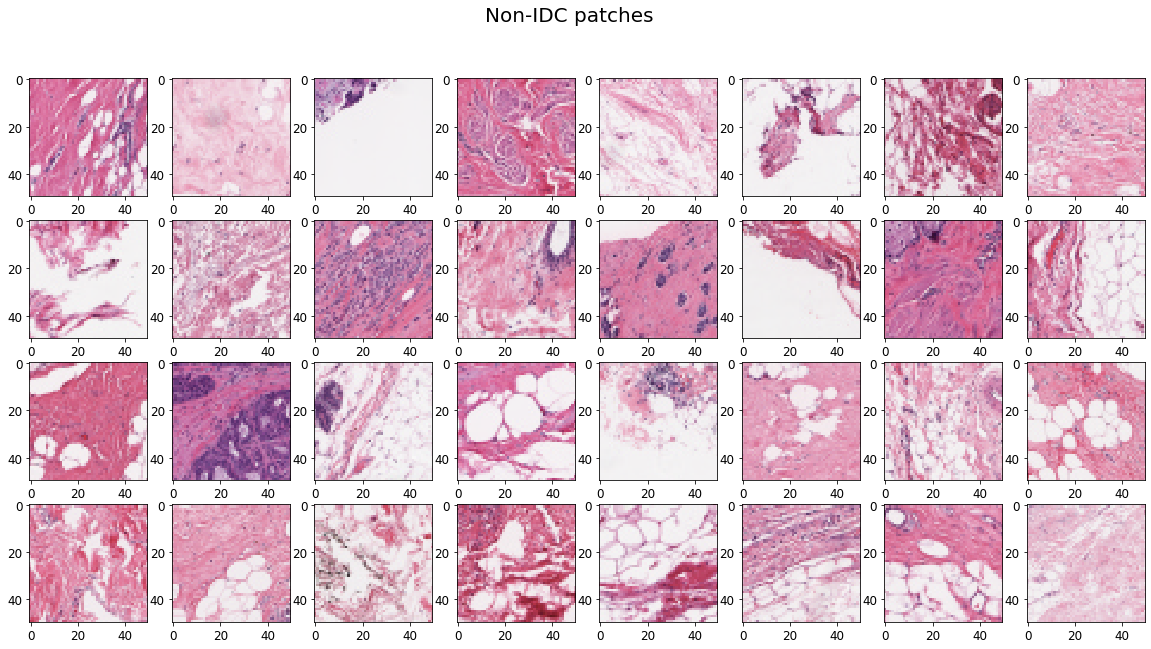

In [153]:
# Non-IDC patches
fig, ax = plt.subplots(4, 8, figsize=(20, 10))

for i in range(4):
    for j in range(8):
        idx = non_idc_sample[j + 8*i]
        image = imread(data.loc[idx, 'path'])
        ax[i,j].imshow(image)
        
fig.suptitle('Non-IDC patches', fontsize=20)
plt.show()

#### Show full IDC/Non-IDC patches using scatter plot

In [142]:
def scatter_plot_by_patient_id(patient_id):
    df = data[data.patient_id == patient_id]
    
    g = sns.scatterplot(data=df, x="x", y="y", hue="target")
    g.set_title('Patient: ' + str(patient_id), fontsize=20)
    g.grid()

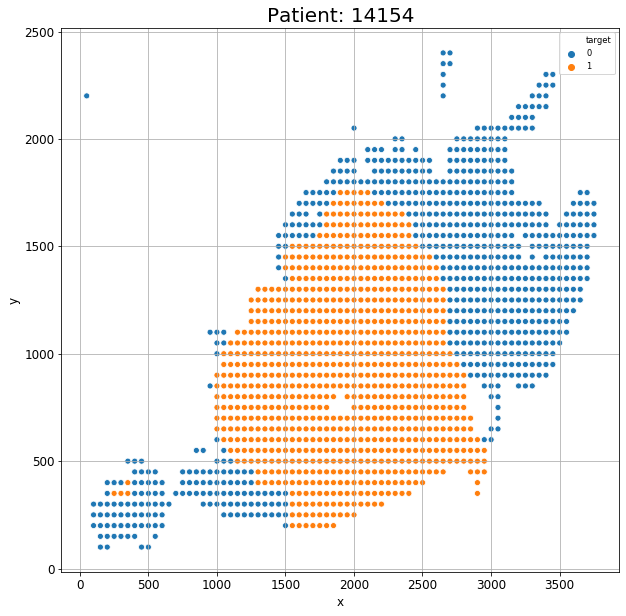

In [143]:
scatter_plot_by_patient_id(14154)

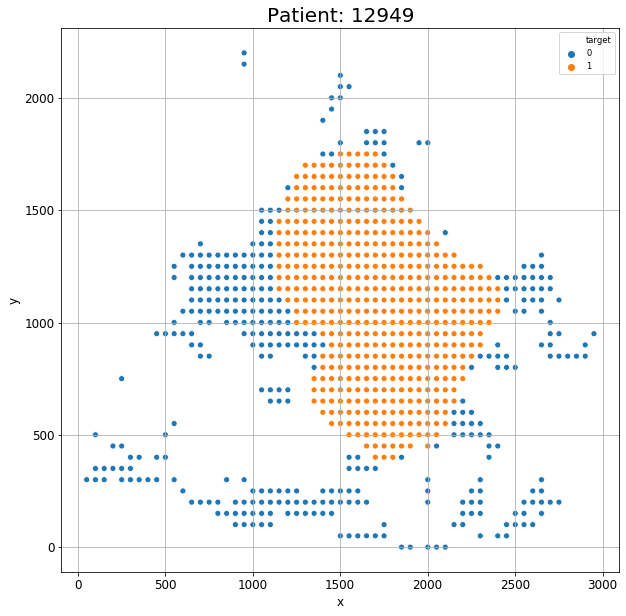

In [144]:
scatter_plot_by_patient_id(12949)

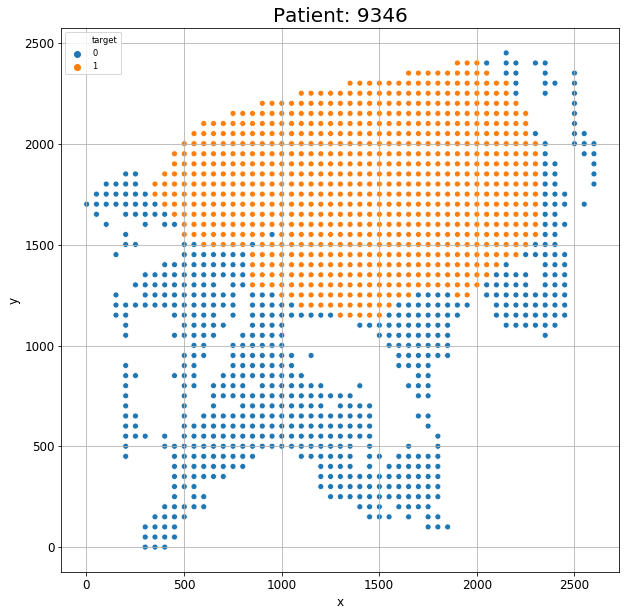

In [145]:
scatter_plot_by_patient_id(9346)

### 4.4. Setting the training set and test set

#### Create Training set/ Validation set/ Test set

In [154]:
train_set, val_test = train_test_split(data, test_size=0.3, random_state=0)
valid_set, test_set = train_test_split(val_test, test_size=0.5, random_state=0)

print('train/val/test: ' + str(len(train_set)) + '/' + str(len(valid_set)) + '/' + str(len(test_set)))

train/val/test: 194266/41629/41629


In [155]:
train_set.head(20)

,patient_id,x,y,path,target
120140,13404,551,1451,../dataset/13404/0/13404_idx5_x551_y1451_class0.png,0
61707,14082,201,1651,../dataset/14082/0/14082_idx5_x201_y1651_class0.png,0
134935,12890,1301,551,../dataset/12890/0/12890_idx5_x1301_y551_class0.png,0
43347,14154,2751,1751,../dataset/14154/0/14154_idx5_x2751_y1751_class0.png,0
156677,12818,2151,1301,../dataset/12818/1/12818_idx5_x2151_y1301_class1.png,1
8691,15471,2001,1201,../dataset/15471/1/15471_idx5_x2001_y1201_class1.png,1
259006,9324,51,1801,../dataset/9324/0/9324_idx5_x51_y1801_class0.png,0
99795,9126,651,1901,../dataset/9126/0/9126_idx5_x651_y1901_class0.png,0
11411,9173,401,351,../dataset/9173/0/9173_idx5_x401_y351_class0.png,0
144239,9290,2201,401,../dataset/9290/0/9290_idx5_x2201_y401_class0.png,0


#### Data Information

In [156]:
train_set.groupby("target")["target"].count()

target
0    139290
1     54976
Name: target, dtype: int64

In [157]:
valid_set.groupby("target")["target"].count()

target
0    29537
1    12092
Name: target, dtype: int64

In [158]:
test_set.groupby("target")["target"].count()

target
0    29911
1    11718
Name: target, dtype: int64

### 4.5. Load data into PyTorch tensors

In [183]:
import torch

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import h5py

In [184]:
class MyDataset(Dataset):
    def __init__(self, df_data, transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        _, _, _, img_path, label = self.df[index] # Only use path and target (not use patient_id, x, y)
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (50,50))
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [185]:
transforms = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

train = MyDataset(train_set, transforms)
valid = MyDataset(valid_set, transforms)
test = MyDataset(test_set, transforms)

In [186]:
train_data_gen = DataLoader(train, shuffle=True, batch_size=20000)
valid_data_gen = DataLoader(valid, batch_size=20000)
test_data_gen = DataLoader(test, batch_size=20000)

In [187]:
dataset_sizes = {
    'train':len(train_data_gen.dataset), 
    'valid':len(valid_data_gen.dataset), 
    'test':len(test_data_gen.dataset),
}

In [188]:
dataset_sizes

{'train': 194266, 'valid': 41629, 'test': 41629}

#### Convert image data to hdf5 format, dividing data into batches

In [189]:
def output_h5py(file_name, X, y):
    file = h5py.File(file_name, 'w')
    
    file.create_dataset('X', data=X)
    file.create_dataset('y', data=y)
    
    file.close()

In [190]:
i = 1

for (x, y) in train_data_gen:
    file_name = '../data_batch_train/X_train_' + str(i) + '.hdf5'
    output_h5py(file_name, x.numpy(), y.numpy())
    i += 1

In [191]:
i = 1

for (x, y) in valid_data_gen:
    file_name = '../data_batch_valid/X_valid_' + str(i) + '.hdf5'
    output_h5py(file_name, x.numpy(), y.numpy())
    i += 1

In [192]:
i = 1

for (x, y) in test_data_gen:
    file_name = '../data_batch_test/X_test_' + str(i) + '.hdf5'
    output_h5py(file_name, x.numpy(), y.numpy())
    i += 1

# 5. Final

- At the end of the implementation on the local machine, the output is batches of data, which will be the input of the deep learning system. 
- The deep learning system will be implemented on Google Colab.